#1. Active Learning with Gaussian Process



In [4]:
## Active regression with ActiveLearner using Gaussian process 
!pip install modAL
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner

In [0]:
%matplotlib inline

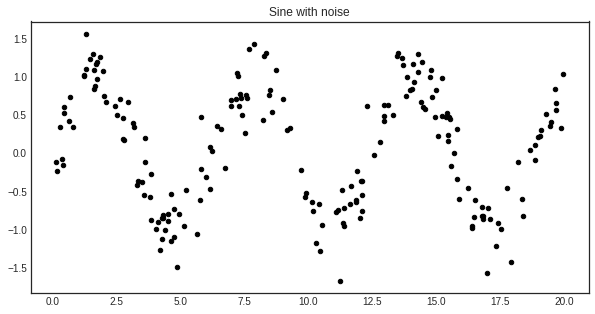

In [6]:
X = np.random.choice(np.linspace(0,20,10000),size=200,replace=False).reshape(-1,1)
y = np.sin(X) + np.random.normal(scale=0.3, size=X.shape)

with plt.style.context('seaborn-white'):
  plt.figure(figsize = (10,5))
  plt.scatter(X, y, c= 'k', s = 20)
  plt.title("Sine with noise")
  plt.show()

In [0]:
# Setting the query strategy to gaussian process regression
# This takes in an estimator and a bunch of data and turn it into an instance 
# estimator / classifier here is gaussian process regression 

def GP_regression_std(regressor, X):
    # measuring the utility of each instance in the pool 
    _, std = regressor.predict(X, return_std=True)

    # selecting the indices of the instances to be queried 
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

In [0]:
n_initial = 5
initial_idx = np.random.choice(range(len(X)), size=n_initial, replace=False)
X_training, y_training = X[initial_idx], y[initial_idx]

kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

regressor = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_training.reshape(-1, 1), y_training=y_training.reshape(-1, 1)
)

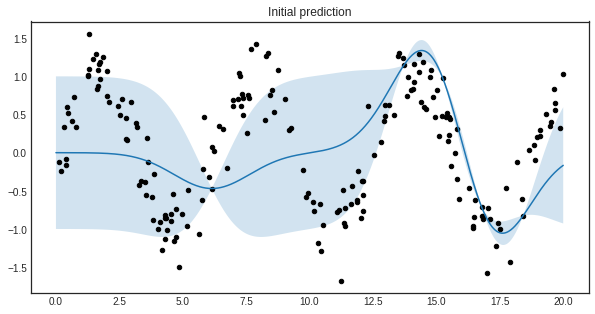

In [10]:
X_grid = np.linspace(0, 20, 1000)
y_pred, y_std = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.plot(X_grid, y_pred)
    plt.fill_between(X_grid, y_pred - y_std, y_pred + y_std, alpha=0.2) 
    # The blue band enveloping the regressor represents the standard deviation 
    # of the Gaussian process at the given point.
    plt.scatter(X, y, c='k', s=20)
    plt.title('Initial prediction')
    plt.show()

# The initial regressor is not very accurate 

**Active Learning**

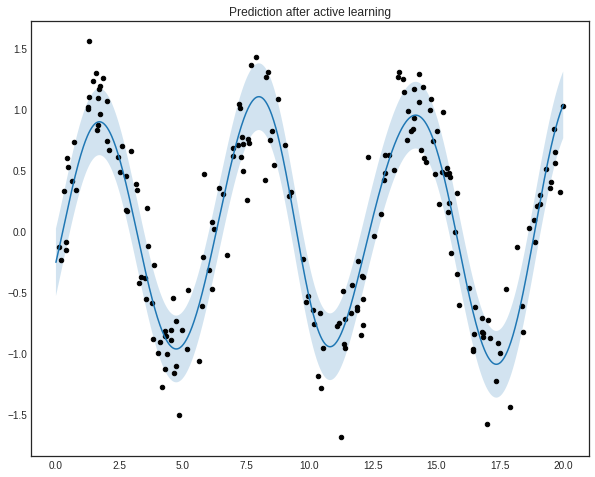

In [14]:
n_queries = 100

# query and then teach 
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(X)
    regressor.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1, -1))

y_pred_final, y_std_final = regressor.predict(X_grid.reshape(-1, 1), return_std=True)
y_pred_final, y_std_final = y_pred_final.ravel(), y_std_final.ravel()

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 8))
    plt.plot(X_grid, y_pred_final)
    plt.fill_between(X_grid, y_pred_final - y_std_final, y_pred_final + y_std_final, alpha=0.2)
    plt.scatter(X, y, c='k', s=20)
    plt.title('Prediction after active learning')
    plt.show()

# 2. Bayesian Optimizer Model 